In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime as dt, timedelta as td

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [25]:
# View all of the classes that automap found
# Get all the class names
class_names = Base.classes.keys()

# Print the class names
for class_name in class_names:
    print(class_name)

measurement
station


In [26]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

The date one year from the last date in the data set is 2016-08-23.


<AxesSubplot:xlabel='Date', ylabel='Inches'>

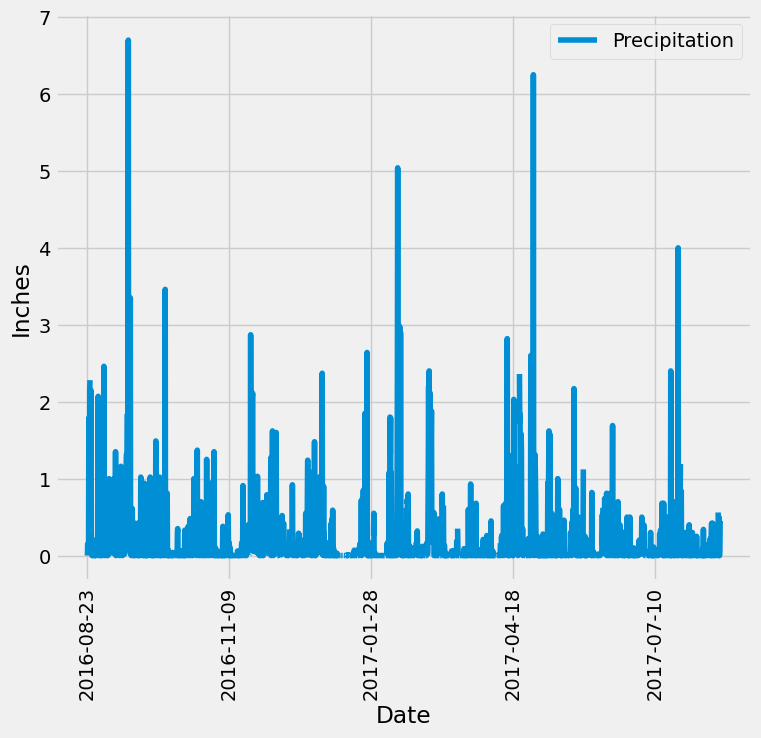

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = (dt.strptime(recent_date, '%Y-%m-%d').date() - td(days=365)).strftime('%Y-%m-%d')

print(f"The date one year from the last date in the data set is {one_year_ago}.")

# Perform a query to retrieve the data and precipitation scores
data_prec = session.query(Measurement.date, Measurement.prcp)\
                  .filter(Measurement.date >= one_year_ago)\
                  .order_by(Measurement.date)\
                  .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
p_df = pd.DataFrame(data_prec, columns=['Date', 'Precipitation'])

#set the index to the date column
p_df.set_index("Date", inplace=True)

# Sort the dataframe by date
p_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
p_df.plot(figsize=(8, 7), rot=90, legend=True, grid=True, xlabel="Date", ylabel="Inches")



In [30]:
p_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
p_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
total_stations=session.query(func.count(Station.station.distinct())).scalar()
total_stations

9

In [33]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station= session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)\
                              .filter(Measurement.station=='USC00519281')).all()
active_station

[(53.0, 87.0, 71.66378066378067)]

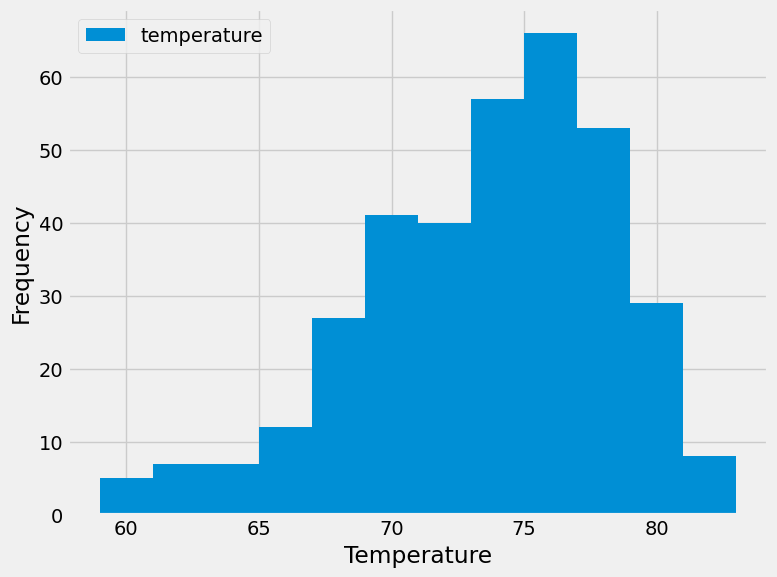

In [35]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .first()[0]
temperature_data = session.query(Measurement.tobs) \
    .filter(Measurement.date >= one_year_ago) \
    .filter(Measurement.station == most_active_station ) \
    .all()
# Convert the query results to a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])
# Convert one_year_ago to a datetime object
one_year_ago = dt.strptime(one_year_ago, '%Y-%m-%d')

# Plot the results as a histogram
temperature_df.plot.hist(bins=12, figsize=(8, 6), linewidth=0.5)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [36]:
# Close Session
session.close()